In [38]:
import pandas as pd
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import csv
import skimage.filters as filters

**Read image data**

In [39]:
def get_image(fname):    
    """
    Get an image from a filepath in ndarray format
    """
    return np.array(Image.open(fname))

In [40]:
chip_name='104.tif'

In [41]:
img =get_image(chip_name)

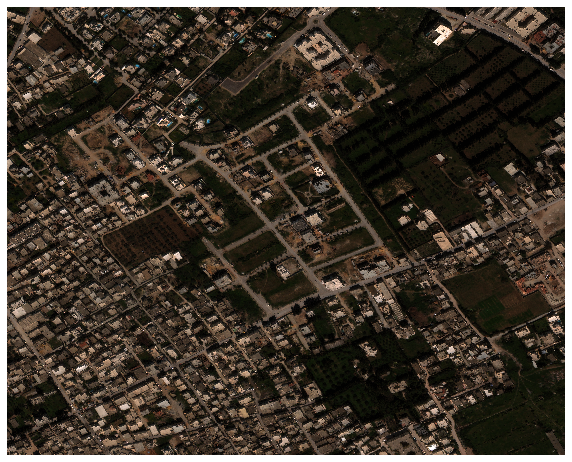

In [42]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)

**Read label data**

In [43]:
def get_labels(fname="xView_train.geojson"):
    
    with open(fname) as f:
        data = json.load(f)
    
    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))
    
    for i in range(len(data['features'])):
        if data['features'][i]['properties']['bounds_imcoords'] != []:
            b_id = data['features'][i]['properties']['image_id']
            val = np.array([int(num) for num in data['features'][i]['properties']['bounds_imcoords'].split(",")])
            chips[i] = b_id
            classes[i] = data['features'][i]['properties']['type_id']
            coords[i] = val
        else:
            chips[i] = 'None'
            
    return coords, chips, classes

In [45]:
coords, chips, classes= get_labels()

In [59]:
coords

array([[2712., 1145., 2746., 1177.],
       [2720., 2233., 2760., 2288.],
       [2687., 1338., 2740., 1399.],
       ...,
       [2106.,  361., 2124.,  379.],
       [1917.,   38., 1958.,   64.],
       [2323.,   55., 2349.,   74.]])

In [57]:
import collections, numpy
collections.Counter(chips)

Counter({'2355.tif': 2348,
         '2356.tif': 1400,
         '2370.tif': 1945,
         '2371.tif': 1711,
         '2384.tif': 2540,
         '2386.tif': 1748,
         '2387.tif': 1587,
         '2398.tif': 2378,
         '2399.tif': 1065,
         '2268.tif': 3,
         '2270.tif': 2,
         '2278.tif': 21,
         '2279.tif': 327,
         '2281.tif': 67,
         '2292.tif': 553,
         '2293.tif': 767,
         '2294.tif': 207,
         '2301.tif': 1113,
         '2303.tif': 478,
         '2305.tif': 790,
         '2306.tif': 306,
         '2308.tif': 2610,
         '2309.tif': 100,
         '2313.tif': 3036,
         '2314.tif': 959,
         '2322.tif': 1019,
         '2334.tif': 149,
         '2408.tif': 428,
         '2421.tif': 297,
         '2423.tif': 1798,
         '1559.tif': 34,
         '1562.tif': 3,
         '1577.tif': 8,
         '1579.tif': 12,
         '1580.tif': 85,
         '1581.tif': 19,
         '1600.tif': 46,
         '1602.tif': 172,
         '160

In [15]:
#We only want to coordinates and classes that are within our chip
coords = coords[chips==chip_name]
classes = classes[chips==chip_name].astype(np.int64)

In [16]:
labels = {}
with open('xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

In [17]:
print([labels[i] for i in np.unique(classes)])

['Small Car', 'Bus', 'Truck', 'Cargo Truck', 'Trailer', 'Scraper/Tractor', 'Shed', 'Building', 'Damaged Building']


**Chip image into 300*300 pixel images**

In [18]:
def chip_image(img,coords,classes,shape=(300,300)):
    """
    Chip an image and get relative coordinates and classes.  Bounding boxes that pass into
        multiple chips are clipped: each portion that is in a chip is labeled. For example,
        half a building will be labeled if it is cut off in a chip. If there are no boxes,
        the boxes array will be [[0,0,0,0]] and classes [0].
        Note: This chip_image method is only tested on xView data-- there are some image manipulations that can mess up different images.
    Args:
        img: the image to be chipped in array format
        coords: an (N,4) array of bounding box coordinates for that image
        classes: an (N,1) array of classes for each bounding box
        shape: an (W,H) tuple indicating width and height of chips
    Output:
        An image array of shape (M,W,H,C), where M is the number of chips,
        W and H are the dimensions of the image, and C is the number of color
        channels.  Also returns boxes and classes dictionaries for each corresponding chip.
    """
    height,width,_ = img.shape
    wn,hn = shape
    
    w_num,h_num = (int(width/wn),int(height/hn))
    images = np.zeros((w_num*h_num,hn,wn,3))
    total_boxes = {}
    total_classes = {}
    
    k = 0
    for i in range(w_num):
        for j in range(h_num):
            x = np.logical_or( np.logical_and((coords[:,0]<((i+1)*wn)),(coords[:,0]>(i*wn))),
                               np.logical_and((coords[:,2]<((i+1)*wn)),(coords[:,2]>(i*wn))))
            out = coords[x]
            y = np.logical_or( np.logical_and((out[:,1]<((j+1)*hn)),(out[:,1]>(j*hn))),
                               np.logical_and((out[:,3]<((j+1)*hn)),(out[:,3]>(j*hn))))
            outn = out[y]
            out = np.transpose(np.vstack((np.clip(outn[:,0]-(wn*i),0,wn),
                                          np.clip(outn[:,1]-(hn*j),0,hn),
                                          np.clip(outn[:,2]-(wn*i),0,wn),
                                          np.clip(outn[:,3]-(hn*j),0,hn))))
            box_classes = classes[x][y]
        
            if out.shape[0] != 0:
                total_boxes[k] = out
                total_classes[k] = box_classes
            else:
                total_boxes[k] = np.array([[0,0,0,0]])
                total_classes[k] = np.array([0])
            
            chip = img[hn*j:hn*(j+1),wn*i:wn*(i+1),:3]
            images[k]=chip
            
            k = k + 1
    
    return images.astype(np.uint8),total_boxes,total_classes

In [61]:
c_img, c_box, c_cls = chip_image(img = img, coords= coords, classes=classes, shape=(300,300))
c_img.shape

(99, 300, 300, 3)

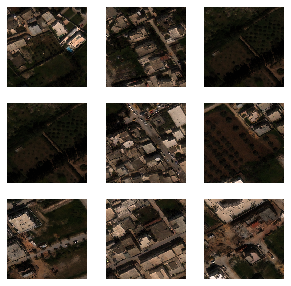

In [23]:


#We can plot some of the chips
fig,ax = plt.subplots(3)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(9):
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()



**Draw bounding boxes**

In [24]:
def draw_bboxes(img,boxes):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])

    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        
        for j in range(3):
            draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
    return source

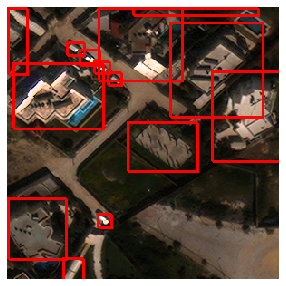

In [25]:
ind = np.random.choice(range(c_img.shape[0]))
labelled = draw_bboxes(c_img[ind],c_box[ind])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(labelled)

**DATA AUGMENTATION**

**Scalar shift**

In [26]:
def shift_image(image,bbox):
    """
    Shift an image by a random amount on the x and y axis drawn from discrete  
        uniform distribution with parameter min(shape/10)
    Args:
        image: the image to be shifted in array format
        bbox: an (N,4) array of boxes for the image
    Output:
        The shifted image and corresponding boxes
    """
    shape = image.shape[:2]
    maxdelta = min(shape)/10
    dx,dy = np.random.randint(-maxdelta,maxdelta,size=(2))
    newimg = np.zeros(image.shape,dtype=np.uint8)
    
    nb = []
    for box in bbox:
        xmin,xmax = np.clip((box[0]+dy,box[2]+dy),0,shape[1])
        ymin,ymax = np.clip((box[1]+dx,box[3]+dx),0,shape[0])

        #we only add the box if they are not all 0
        if not(xmin==0 and xmax ==0 and ymin==0 and ymax ==0):
            nb.append([xmin,ymin,xmax,ymax])
    
    newimg[max(dx,0):min(image.shape[0],image.shape[0]+dx),
           max(dy,0):min(image.shape[1],image.shape[1]+dy)] = \
    image[max(-dx,0):min(image.shape[0],image.shape[0]-dx),
          max(-dy,0):min(image.shape[1],image.shape[1]-dy)]
    
    return newimg, nb

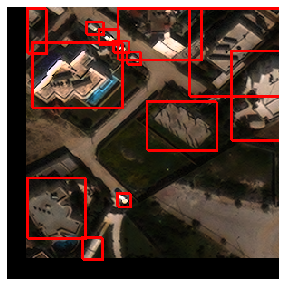

In [27]:
i1,b1 = shift_image(c_img[ind],c_box[ind])
a1 = draw_bboxes(i1,b1)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a1)

**Rotation**

In [28]:
def rotate_image_and_boxes(img, deg, pivot, boxes):
    """
    Rotates an image and corresponding bounding boxes.  Bounding box rotations are kept axis-aligned,
        so multiples of non 90-degrees changes the area of the bounding box.
    Args:
        img: the image to be rotated in array format
        deg: an integer representing degree of rotation
        pivot: the axis of rotation. By default should be the center of an image, but this can be changed.
        boxes: an (N,4) array of boxes for the image
    Output:
        Returns the rotated image array along with correspondingly rotated bounding boxes
    """

    if deg < 0:
        deg = 360-deg
    deg = int(deg)
        
    angle = 360-deg
    padX = [img.shape[0] - pivot[0], pivot[0]]
    padY = [img.shape[1] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX, [0,0]], 'constant').astype(np.uint8)
    #scipy ndimage rotate takes ~.7 seconds
    #imgR = ndimage.rotate(imgP, angle, reshape=False)
    #PIL rotate uses ~.01 seconds
    imgR = Image.fromarray(imgP).rotate(angle)
    imgR = np.array(imgR)
    
    theta = deg * (np.pi/180)
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    #  [(cos(theta), -sin(theta))] DOT [xmin, xmax] = [xmin*cos(theta) - ymin*sin(theta), xmax*cos(theta) - ymax*sin(theta)]
    #  [sin(theta), cos(theta)]        [ymin, ymax]   [xmin*sin(theta) + ymin*cos(theta), xmax*cos(theta) + ymax*cos(theta)]

    newboxes = []
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        #The 'x' values are not centered by the x-center (shape[0]/2)
        #but rather the y-center (shape[1]/2)
        
        xmin -= pivot[1]
        xmax -= pivot[1]
        ymin -= pivot[0]
        ymax -= pivot[0]

        bfull = np.array([ [xmin,xmin,xmax,xmax] , [ymin,ymax,ymin,ymax]])
        c = np.dot(R,bfull) 
        c[0] += pivot[1]
        c[0] = np.clip(c[0],0,img.shape[1])
        c[1] += pivot[0]
        c[1] = np.clip(c[1],0,img.shape[0])
        
        if np.all(c[1] == img.shape[0]) or np.all(c[1] == 0):
            c[0] = [0,0,0,0]
        if np.all(c[0] == img.shape[1]) or np.all(c[0] == 0):
            c[1] = [0,0,0,0]

        newbox = np.array([np.min(c[0]),np.min(c[1]),np.max(c[0]),np.max(c[1])]).astype(np.int64)

        if not (np.all(c[1] == 0) and np.all(c[0] == 0)):
            newboxes.append(newbox)
    
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]], newboxes

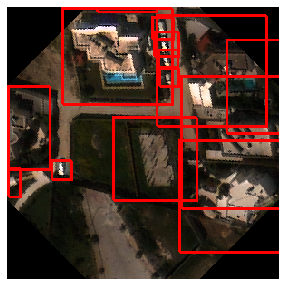

In [32]:
center = (int(c_img[ind].shape[0]/2),int(c_img[ind].shape[1]/2))
i2,b2 = rotate_image_and_boxes(c_img[ind],45, center, c_box[ind])
a2 = draw_bboxes(i2,b2)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a2)

**Salt and pepper augmentation**

In [43]:
def salt_and_pepper(img,prob=.005):
    """
    Applies salt and pepper noise to an image with given probability for both.
    Args:
        img: the image to be augmented in array format
        prob: the probability of applying noise to the image
    Output:
        Augmented image
    """

    newimg = np.copy(img)
    whitemask = np.random.randint(0,int((1-prob)*200),size=img.shape[:2])
    blackmask = np.random.randint(0,int((1-prob)*200),size=img.shape[:2])
    newimg[whitemask==0] = 255
    newimg[blackmask==0] = 0
        
    return newimg

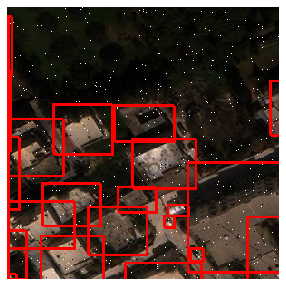

In [44]:
i3=salt_and_pepper(c_img[ind])
a3 = draw_bboxes(i3,c_box[ind])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a3)

**Gaussian Blur**

In [45]:
def gaussian_blur(img, max_sigma=1.5):
    """
    Use a gaussian filter to blur an image
    Args:
        img: image to be augmented in array format
        max_sigma: the maximum variance for gaussian blurring
    Output:
        Augmented image
    """
    return (filters.gaussian(img,np.random.random()*max_sigma,multichannel=True)*255).astype(np.uint8)

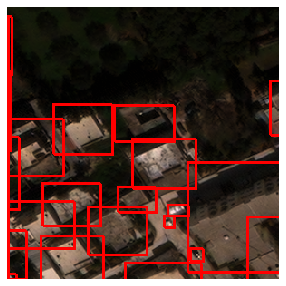

In [46]:
i4=gaussian_blur(c_img[ind])
a4 = draw_bboxes(i4,c_box[ind])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a4)